<a href="https://colab.research.google.com/github/yuvalofek/Deep_Learning/blob/master/DeepLearningAssignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ECE472, Deep Learning – Assignment 2**

Submit by Sept. 23, 10pm

tldr: Classify mnist digits with a (optionally convoultional) neural network. Get at least 95.5% accuracy on the test test.

In [1]:
import numpy as np
import pandas as pd
import numpy.random as npr
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import gzip

In [2]:
npr.seed(25)
image_size = 28
train_images = 60_000
test_images = 10_000

#Install MNIST dataset
!wget -O train-images-idx3-ubyte.gz http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget -O train-labels-idx1-ubyte.gz http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget -O t10k-images-idx3-ubyte.gz http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget -O t10k-labels-idx1-ubyte.gz http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

# To read these files I referenced: 


def read_values(file_name , read_val, size, num_read):
  '''
  Opens gzip compressed file with name file_name and reads the values in it, 
  returning an array of integers of size: (size*size*num_read,), containing the
  information inside the file. 
  
  Referenced:
  https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python 
  '''
  f = gzip.open(file_name, 'r')
  f.read(read_val)
  buf = f.read(size*size * num_read)
  data = np.frombuffer(buf, dtype=np.uint8).astype('int')
  return data

#read the values
data_tr = read_values('train-images-idx3-ubyte.gz',
                      16,image_size,train_images).reshape(train_images,-1)
label_tr = read_values('train-labels-idx1-ubyte.gz',
                       8,1,train_images)
data_test = read_values('t10k-images-idx3-ubyte.gz',
                        16,image_size,test_images).reshape(test_images,-1)
label_test = read_values('t10k-labels-idx1-ubyte.gz',
                         8,1,test_images)

#Make into dataframes because I find them nicer to work with
df_X_train = pd.DataFrame(
    np.concatenate((np.expand_dims(label_tr, axis = 1), data_tr), axis = 1), 
    dtype = 'int'
    )
df_X_test = pd.DataFrame(
    np.concatenate((np.expand_dims(label_test, axis = 1), data_test), axis = 1), 
    dtype = 'int'
    )


--2020-09-22 02:20:30--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.28.6.204, 172.67.171.76, 104.28.7.204, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.28.6.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  31.9MB/s    in 0.3s    

2020-09-22 02:20:31 (31.9 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2020-09-22 02:20:31--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.28.6.204, 172.67.171.76, 104.28.7.204, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.28.6.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===================>]  28.20K  --.-KB

In [3]:
### CREATING THE VALIDATION SET:
VAL_PERCENT = 0.1
num_examples = len(df_X_train)

#How many examples to put in validation set
num_val_examples = VAL_PERCENT* num_examples
#number of examples with each label in current training set
num_examples_per_class = df_X_train.groupby(0)[0].count()
#number of examples from each label to move have in validation set 
val_per_class = list((np.around(
    num_examples_per_class/num_examples*num_val_examples
    ).astype('int')))
#number of labels
num_classes =len(num_examples_per_class)

#For each label in current training set, randomly pick examples 
#so that their number match what was calculated earlier and add it
#to a big list
val_idxs = []
for i in range(num_classes):
  val_idxs.append(npr.choice(df_X_train[df_X_train[0] == i].index,
                             size = val_per_class[i]).tolist())
val_idxs = [item for sublist in val_idxs for item in sublist]

#take those chosen examples and make a validation set, while also 
#removing them from the training set
df_X_val = df_X_train.loc[val_idxs]
df_X_train = df_X_train.drop(val_idxs)


#checking to make sure validation and training sets have same distribution
percent_classes_train = list(df_X_train.groupby(0)[0].count()/len(df_X_train))
percent_classes_val = list(df_X_val.groupby(0)[0].count()/len(df_X_val))

print('All probabilities match up to 1e-3:',
    any([(percent_classes_train[i] - percent_classes_val[i])<1e-3
 for i in range(len(percent_classes_val)) ]))

All probabilities match up to 1e-3: True


In [4]:
#extract labels
df_y_train = df_X_train.pop(0)
df_y_test = df_X_test.pop(0)
df_y_val = df_X_val.pop(0)

#to numpy and reshapes
X_train = df_X_train.to_numpy().reshape(-1, 28,28, 1)
y_train = df_y_train.to_numpy()

X_val = df_X_val.to_numpy().reshape(-1,28,28, 1)
y_val = df_y_val.to_numpy()

X_test = df_X_test.to_numpy().reshape(-1,28,28, 1)
y_test = df_y_test.to_numpy()

#make y categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

# Training generator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    shear_range = 0.1,
    zoom_range = 0.05,
    fill_mode = 'nearest'
)
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=32,
)     

#Validation generator
val_datagen = ImageDataGenerator(
    rescale = 1./255
)
val_generator = val_datagen.flow(
    X_val,
    y_val,
)

#Test generator
test_datagen = ImageDataGenerator(
    rescale = 1./255
)
test_generator = test_datagen.flow(
    X_test,
    y_test,
)

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), input_shape = (28,28,1),
                           activation = 'relu',
                           activity_regularizer='l2'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu',
                           activity_regularizer='l2'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation = 'relu', activity_regularizer='l2'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes,activation = 'softmax'),
])

# Compile Model. 
model.compile(loss = "categorical_crossentropy" , 
             optimizer = 'adam', 
             metrics = ['acc'])

# Callback class that stops training once validation accuracy reaches 96%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>0.96):
      print("\n\nValidation reached 96% accuracy so stopping training!")
      self.model.stop_training = True
      
callback = myCallback()

# Train the Model
history = model.fit(
    train_generator,
    epochs = 30,
    verbose = 1,
    validation_data = val_generator,
    callbacks = [callback]
)

Epoch 1/30
1697/1697 [==============================] - 53s 31ms/step - loss: 1.7722 - acc: 0.3829 - val_loss: 0.8630 - val_acc: 0.8800
Epoch 2/30
1697/1697 [==============================] - 54s 32ms/step - loss: 1.2634 - acc: 0.5857 - val_loss: 0.5565 - val_acc: 0.9245
Epoch 3/30
1697/1697 [==============================] - 54s 32ms/step - loss: 1.0899 - acc: 0.6454 - val_loss: 0.5196 - val_acc: 0.9047
Epoch 4/30
1697/1697 [==============================] - 54s 32ms/step - loss: 1.0100 - acc: 0.6688 - val_loss: 0.4253 - val_acc: 0.9310
Epoch 5/30
1697/1697 [==============================] - 54s 32ms/step - loss: 0.9462 - acc: 0.6885 - val_loss: 0.3698 - val_acc: 0.9385
Epoch 6/30
1697/1697 [==============================] - 55s 33ms/step - loss: 0.9195 - acc: 0.6941 - val_loss: 0.3272 - val_acc: 0.9480
Epoch 7/30
1697/1697 [==============================] - 55s 33ms/step - loss: 0.8914 - acc: 0.7025 - val_loss: 0.3427 - val_acc: 0.9350
Epoch 8/30
1697/1697 [==========================

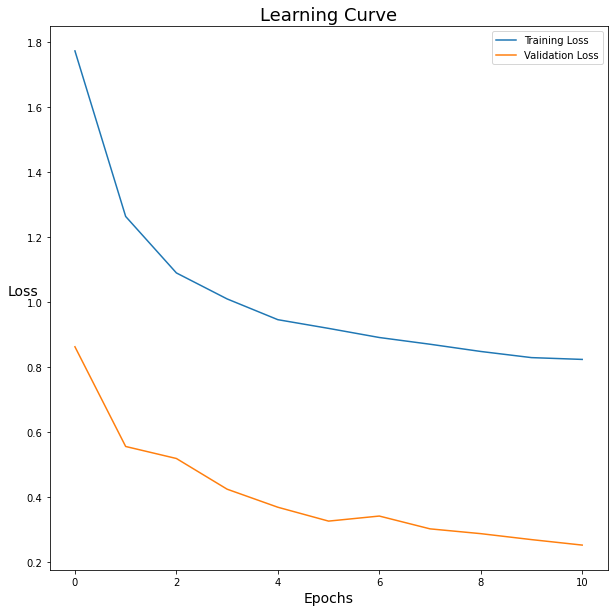

In [9]:
# Learning Curve
plt.figure(figsize = (10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epochs', fontsize = 14)
h = plt.ylabel('Loss',fontsize = 14)
h.set_rotation(0)
plt.title('Learning Curve', fontsize = 18)
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [10]:
results = model.evaluate(test_generator, verbose=0)
print('Test Accuracy:', results[1])

Test Accuracy: 0.958899974822998
